In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from pts.dataset.repository.datasets import dataset_recipes

from time_blend import TimeBlendEstimator

Setting ds_accelerator to cuda (auto detect)


## Prepeare data set

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)

In [4]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [5]:
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)

In [6]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

## Evaluator

In [7]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

## ` TimeBlend-RNN`

In [22]:
estimator = TimeBlendEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=3,
    dropout_rate=0.1,
    lags_seq=[1, 24 * 7],

    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling="none",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu"),
)

In [23]:
predictor = estimator.train(dataset_train, cache_data=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params | In sizes | Out sizes        
------------------------------------------------------------------------
0 | model | TimeBlendModel | 248 K  | ?        | [1, 100, 24, 137]

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 110.54089 (best 110.54089), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_105/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 3.89754 (best 3.89754), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_105/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 2.10467 (best 2.10467), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_105/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 2.00196 (best 2.00196), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_105/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 1.85070 (best 1.85070), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_105/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 1

Epoch 77, global step 3900: 'train_loss' was not in top 1
Epoch 78, global step 3950: 'train_loss' reached 1.10780 (best 1.10780), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_105/checkpoints/epoch=78-step=3950.ckpt' as top 1
Epoch 79, global step 4000: 'train_loss' was not in top 1
Epoch 80, global step 4050: 'train_loss' was not in top 1
Epoch 81, global step 4100: 'train_loss' was not in top 1
Epoch 82, global step 4150: 'train_loss' was not in top 1
Epoch 83, global step 4200: 'train_loss' was not in top 1
Epoch 84, global step 4250: 'train_loss' was not in top 1
Epoch 85, global step 4300: 'train_loss' was not in top 1
Epoch 86, global step 4350: 'train_loss' was not in top 1
Epoch 87, global step 4400: 'train_loss' reached 1.09879 (best 1.09879), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_105/checkpoints/epoch=87-step=4400.ckpt' as top 1
Epoch 88, global step 4450: 'train_loss' reached 1.09251 (best 1.09251), saving model to '

In [24]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))


Running evaluation: 7it [00:00, 109.19it/s]

Running evaluation: 7it [00:00, 110.85it/s]

Running evaluation: 7it [00:00, 110.65it/s]

Running evaluation: 7it [00:00, 109.73it/s]

Running evaluation: 7it [00:00, 109.39it/s]

Running evaluation: 7it [00:00, 110.24it/s]

Running evaluation: 7it [00:00, 109.98it/s]

Running evaluation: 7it [00:00, 109.52it/s]

Running evaluation: 7it [00:00, 109.61it/s]

Running evaluation: 7it [00:00, 109.68it/s]

Running evaluation: 7it [00:00, 109.82it/s]

Running evaluation: 7it [00:00, 110.14it/s]

Running evaluation: 7it [00:00, 109.96it/s]

Running evaluation: 7it [00:00, 110.60it/s]

Running evaluation: 7it [00:00, 109.49it/s]

Running evaluation: 7it [00:00, 110.32it/s]

Running evaluation: 7it [00:00, 110.42it/s]

Running evaluation: 7it [00:00, 110.63it/s]

Running evaluation: 7it [00:00, 110.35it/s]

Running evaluation: 7it [00:00, 109.44it/s]

Running evaluation: 7it [00:00, 109.89it/s]

Running evaluation: 7it [00:00, 110.49it/s]

Running e

### Metrics

In [25]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 1.0078130291395164
ND: 1.0081854562003212
NRMSE: 2.0335236399456225
MSE: 3922.6200008902815


In [19]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.5731134368540688
ND-Sum: 0.5780304238313935
NRMSE-Sum: 0.9360520575467377
MSE-Sum: 15599797.023809522


In [20]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

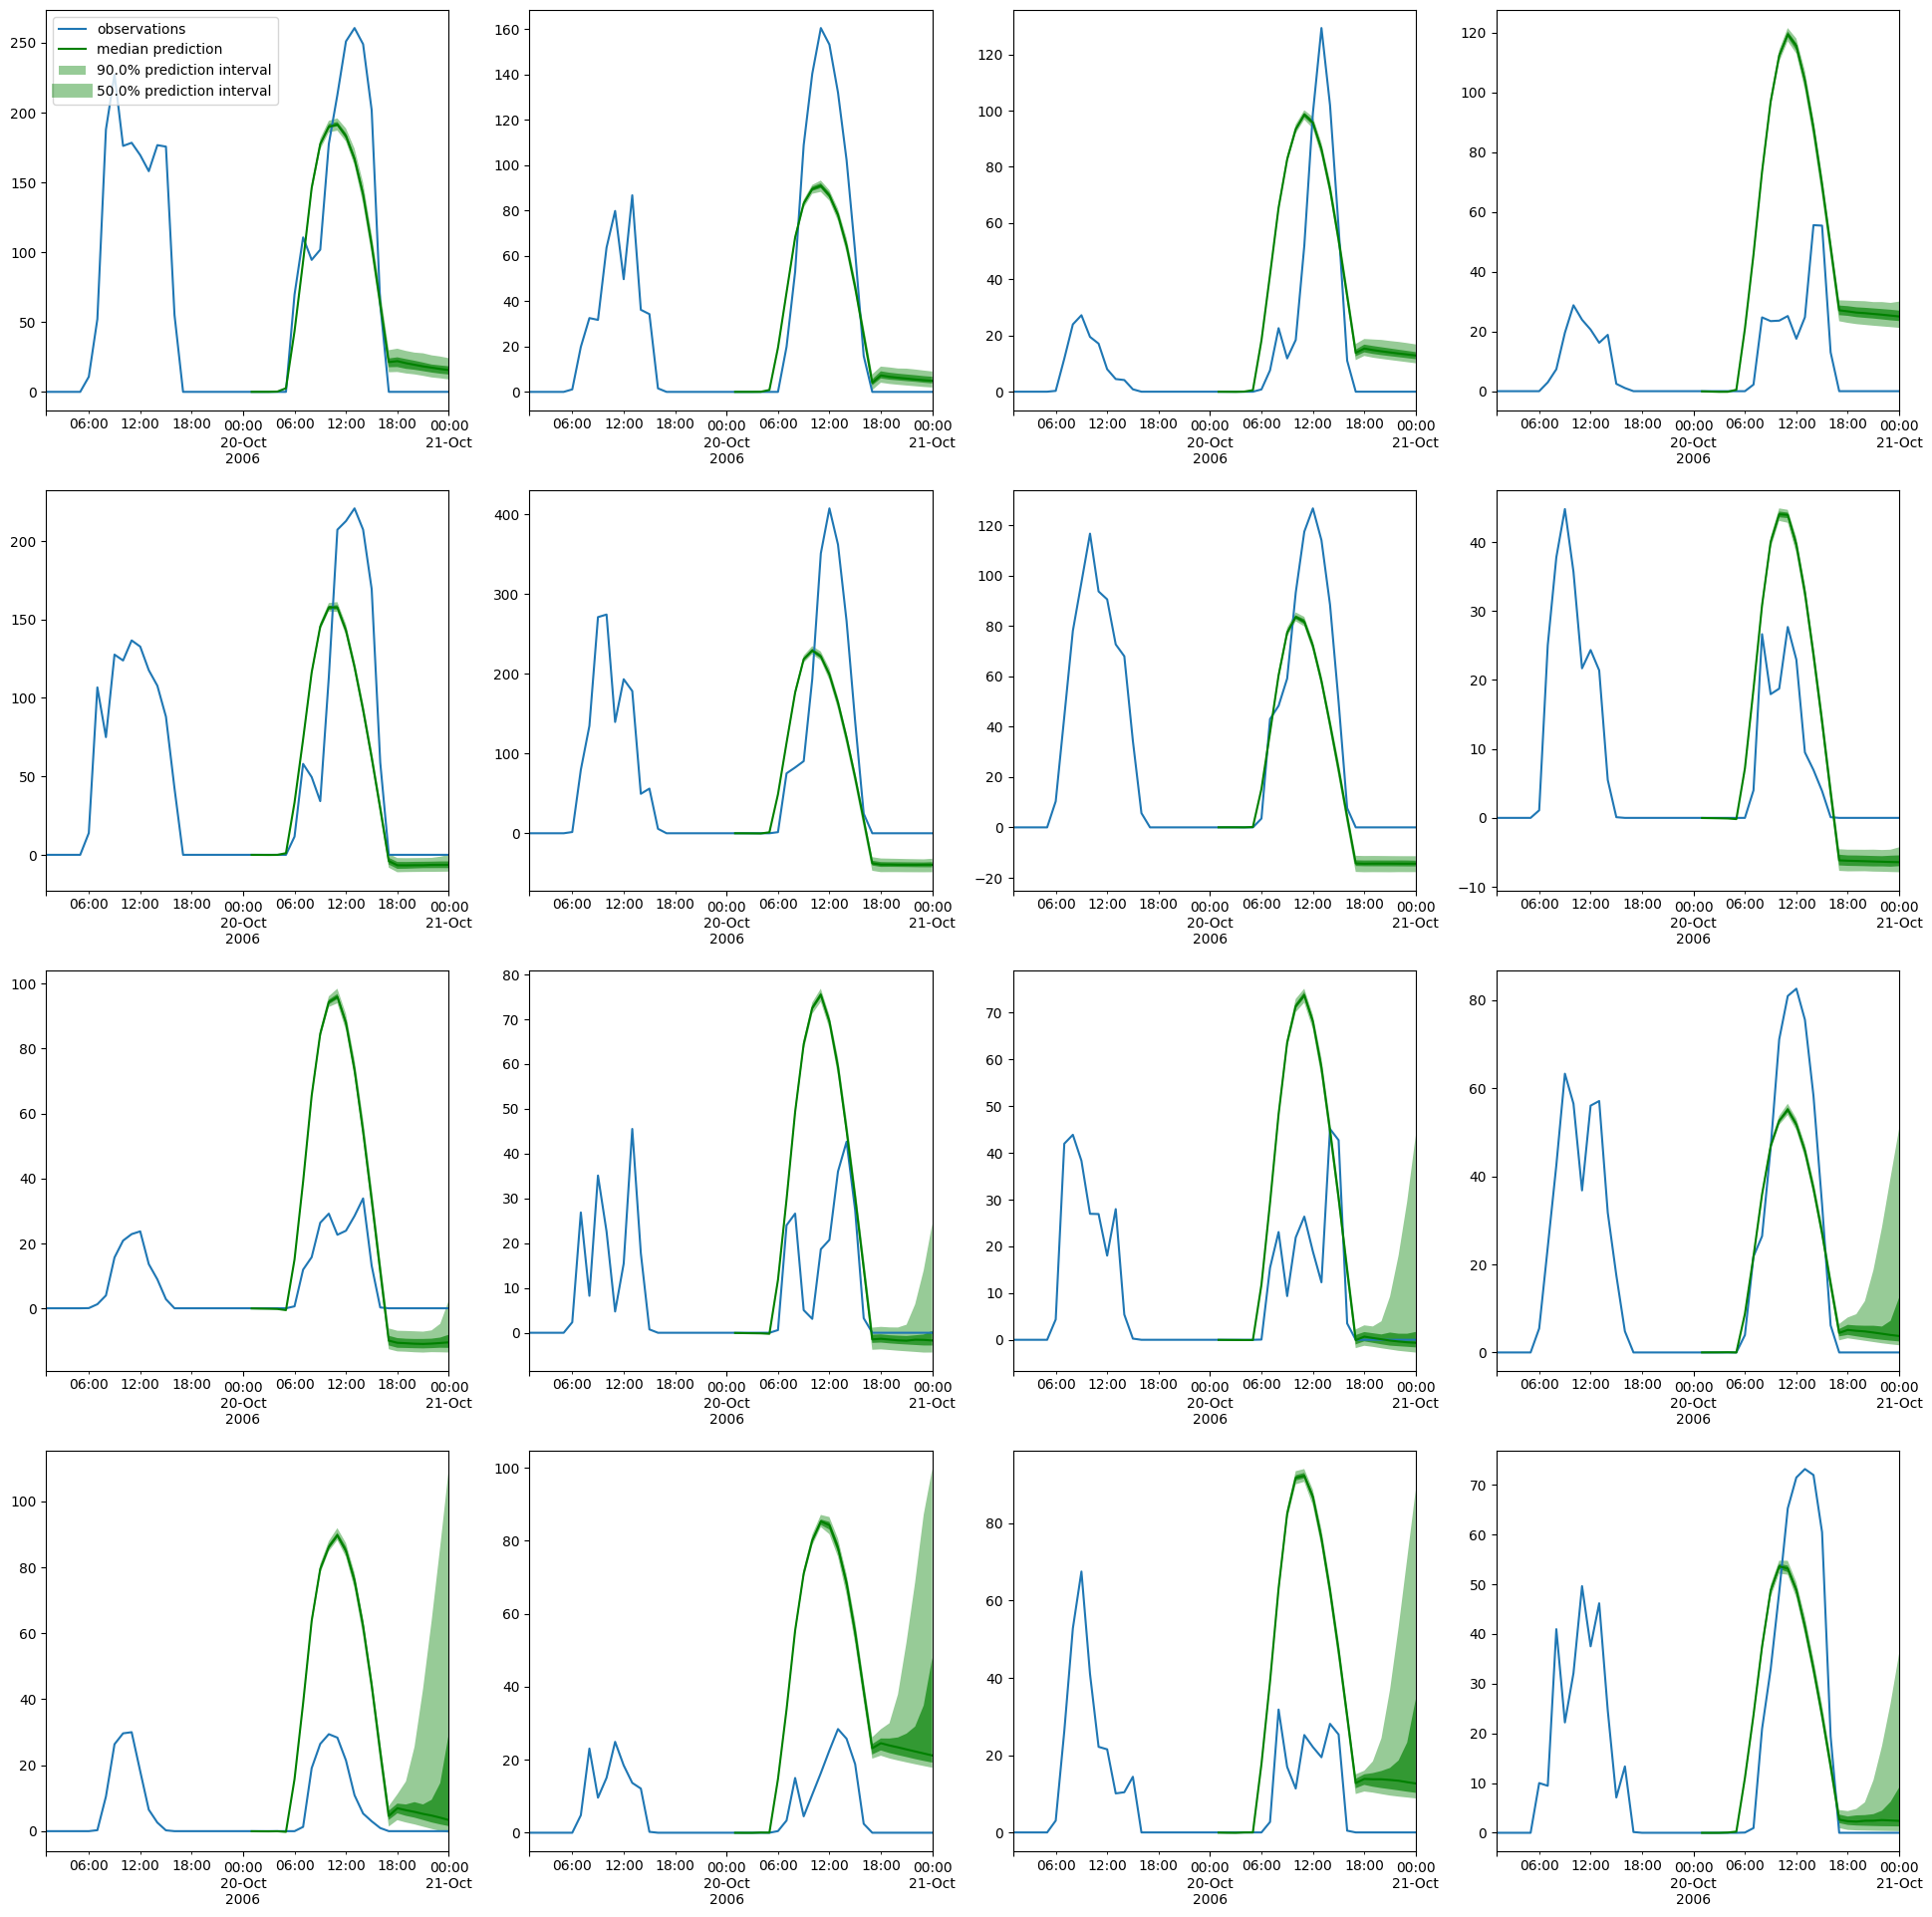

In [21]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()